# Limpieza del Registro de Defunciones 2023  
## Construcción de la variable objetivo: muerte prematura por NCD

En este notebook vamos a:

- Limpiar el Registro de Defunciones generales 2023 de Ecuador.  
- Unificar la edad en años (`edad_anos`).  
- Clasificar cada defunción en 5 grupos según `causa103`:
  - `Cardiovascular`
  - `Cancer`
  - `Diabetes`
  - `Chronic_Respiratory`
  - `No_NCD`
- Construir la variable binaria **`is_premature_ncd`**:

> 1 si la persona tenía entre 30 y 69 años **y** murió por una NCD de los 4 grandes grupos (cardiovascular, cáncer, diabetes, respiratoria crónica).  
> 0 en caso contrario.

Además:

- Prepararemos un dataset **full 2023** para modelado centralizado.  
- Prepararemos un dataset **orientado a 3 “hospitales clientes”** para experimentos de aprendizaje federado.

La estructura de rutas sigue el EDA:

- `../data/raw/INEC_DEFUNCIONESGENERALES_2023.csv`
- `../data/processed/` para guardar versiones limpias.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("default")
sns.set(style="whitegrid")

pd.set_option("display.max_colwidth", 120)

PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

csv_path = DATA_RAW / "INEC_DEFUNCIONESGENERALES_2023.csv"
csv_path

WindowsPath('D:/Archivos de Usuario/Documents/defunciones-fl-ec/data/raw/INEC_DEFUNCIONESGENERALES_2023.csv')

## 2. Carga del dataset original

Se lee el CSV original con:

- Separador `;`
- Codificación `utf-8-sig`
- Todas las columnas como `str` para no perder información.


In [2]:
df_raw = pd.read_csv(
    csv_path,
    sep=";",
    encoding="utf-8-sig",
    dtype=str,
)

df_raw.shape, df_raw.columns

((89877, 45),
 Index(['Numeración', 'prov_insc', 'cant_insc', 'parr_insc', 'anio_insc',
        'mes_insc', 'dia_insc', 'fecha_insc', 'nac_fall', 'cod_pais', 'sexo',
        'anio_nac', 'mes_nac', 'dia_nac', 'fecha_nac', 'anio_fall', 'mes_fall',
        'dia_fall', 'fecha_fall', 'cod_edad', 'edad', 'prov_res', 'sabe_leer',
        'etnia', 'lugar_ocur', 'prov_fall', 'cant_fall', 'parr_fall',
        'muj_fertil', 'mor_viol', 'lug_viol', 'autopsia', 'causa4', 'cer_por',
        'area_fall', 'area_res', 'est_civil', 'niv_inst', 'residente', 'causa',
        'lc1', 'causa103', 'causa80', 'causa67A', 'causa67B'],
       dtype='object'))

Se crea una copia de trabajo `df` y se elimina la columna `Numeración` (identificador interno que no se usará).

In [3]:
df = df_raw.copy()

if "Numeración" in df.columns:
    df = df.drop(columns=["Numeración"])

df.head(3)

,prov_insc,cant_insc,parr_insc,anio_insc,mes_insc,dia_insc,fecha_insc,nac_fall,cod_pais,sexo,...,area_res,est_civil,niv_inst,residente,causa,lc1,causa103,causa80,causa67A,causa67B
0,Guayas,Naranjal,Naranjal,2024,Enero,25,25/1/2024,Ecuatoriana,Ecuador,Hombre,...,Urbano,Viudo (a),Secundaria,No residente,I63 Infarto cerebral,42 Enfermedades cerebrovasculares,069 Enfermedades Cerebro vasculares,055 Enfermedades cerebro vasculares,030 Enfermedades del sistema circulatorio,030 Enfermedades del sistema circulatorio
1,Imbabura,Otavalo,Jordán,2023,Noviembre,27,27/11/2023,Ecuatoriana,Ecuador,Hombre,...,Urbano,Viudo (a),Educación Básica,Residente,I27 Otras enfermedades cardiopulmonares,36 Enfermedad cardiopulmonar y enfermedad de la circulación pulmonar,068 Otras enfermedades del corazón,054 Otras Enfermedades del corazón,030 Enfermedades del sistema circulatorio,030 Enfermedades del sistema circulatorio
2,Cotopaxi,Latacunga,La Matriz,2023,Agosto,4,4/8/2023,Ecuatoriana,Ecuador,Hombre,...,Rural,Viudo (a),Educación Básica,Residente,I62 Otras hemorragias intracraneales no traumáticas,42 Enfermedades cerebrovasculares,069 Enfermedades Cerebro vasculares,055 Enfermedades cerebro vasculares,030 Enfermedades del sistema circulatorio,030 Enfermedades del sistema circulatorio


## 3. Filtro por año de fallecimiento (solo 2023)

El archivo incluye arrastres de años anteriores.  
Se conservan únicamente las defunciones con `anio_fall == '2023'`.


In [4]:
df_2023 = df[df["anio_fall"] == "2023"].copy()
df_2023.shape

(87733, 44)

## 4. Limpieza básica de espacios y valores especiales

1. Se eliminan espacios al inicio/fin en todas las columnas de texto.  
2. Se normalizan valores tipo:
   - `'Sin información'`
   - `''` (cadena vacía)
   - `' '` (espacio solo)

a `NaN` en columnas donde estos códigos significan “dato desconocido”.


In [5]:
# 4.1. Strip global
for col in df_2023.columns:
    df_2023[col] = df_2023[col].astype(str).str.strip()

# 4.2. Función para normalizar "Sin información" a NaN
def normalizar_sin_info(serie: pd.Series) -> pd.Series:
    return serie.replace(
        {
            "Sin información": np.nan,
            "": np.nan,
            " ": np.nan,
        }
    )

cols_sin_info = [
    "nac_fall",
    "etnia",
    "sabe_leer",
    "muj_fertil",
    "mor_viol",
    "lug_viol",
    "autopsia",
    "est_civil",
    "niv_inst",
]

for col in cols_sin_info:
    if col in df_2023.columns:
        df_2023[col] = normalizar_sin_info(df_2023[col])

df_2023[cols_sin_info].head(5)

,nac_fall,etnia,sabe_leer,muj_fertil,mor_viol,lug_viol,autopsia,est_civil,niv_inst
0,Ecuatoriana,Mestizo (a),Si,NaN,NaN,NaN,No,Viudo (a),Secundaria
1,Ecuatoriana,Indígena,Si,NaN,NaN,NaN,No,Viudo (a),Educación Básica
2,Ecuatoriana,Mestizo (a),Si,NaN,NaN,NaN,No,Viudo (a),Educación Básica
3,Ecuatoriana,Mestizo (a),NaN,NaN,NaN,NaN,No,Viudo (a),NaN
4,Ecuatoriana,Mestizo (a),No,NaN,NaN,NaN,No,Viudo (a),Ninguno


## 5. Conversión y estandarización de la edad (`edad_anos`)

La edad se codifica con:

- `cod_edad` ∈ {`Años`, `Meses`, `Días`, `Horas`, `Sin información`}.
- `edad` (numérica, pero almacenada como texto).

Se construye una variable continua **`edad_anos`**:

- `Años` → `edad`
- `Meses` → `edad / 12`
- `Días` → `edad / 365`
- `Horas` → `edad / (24 * 365)`
- `Sin información` u otros códigos → `NaN`


In [6]:
df_2023["edad_num"] = pd.to_numeric(df_2023["edad"], errors="coerce")

def convertir_edad_a_anios(row) -> float:
    cod = row["cod_edad"]
    edad = row["edad_num"]
    if pd.isna(edad):
        return np.nan
    if cod == "Años":
        return edad
    if cod == "Meses":
        return edad / 12.0
    if cod == "Días":
        return edad / 365.0
    if cod == "Horas":
        return edad / (24.0 * 365.0)
    return np.nan

df_2023["edad_anos"] = df_2023.apply(convertir_edad_a_anios, axis=1)

df_2023["edad_anos"].describe()

count    87716.000000
mean        62.887427
std         25.723017
min          0.000000
25%         45.000000
50%         69.000000
75%         83.000000
max        120.000000
Name: edad_anos, dtype: float64

Se revisa visualmente la distribución de `edad_anos` para comprobar que no haya valores atípicos extremos.

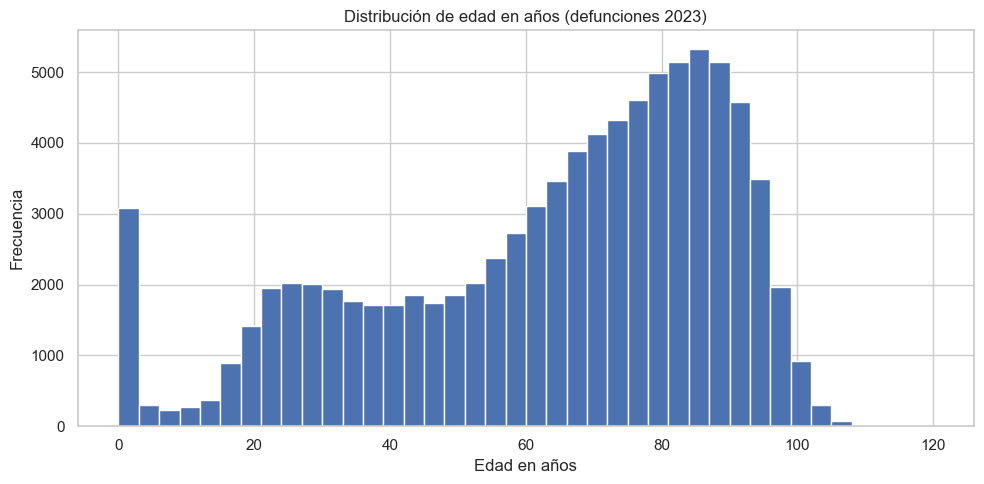

In [7]:
plt.figure(figsize=(10, 5))
df_2023["edad_anos"].plot(kind="hist", bins=40)
plt.title("Distribución de edad en años (defunciones 2023)")
plt.xlabel("Edad en años")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

## 6. Parsing de fechas de nacimiento y fallecimiento (validación básica)

Las fechas se parsean a tipo `datetime` para evaluar su calidad:

- `fecha_nac_dt`
- `fecha_fall_dt`

No se utilizarán directamente como variables de entrada, pero sirven para verificar consistencia.


In [8]:
df_2023["fecha_nac_dt"] = pd.to_datetime(
    df_2023["fecha_nac"], format="%d/%m/%Y", errors="coerce"
)
df_2023["fecha_fall_dt"] = pd.to_datetime(
    df_2023["fecha_fall"], format="%d/%m/%Y", errors="coerce"
)

prop_nac_na = df_2023["fecha_nac_dt"].isna().mean()
prop_fall_na = df_2023["fecha_fall_dt"].isna().mean()
prop_nac_na, prop_fall_na

(np.float64(0.0008548664698574083), np.float64(0.0))

## 7. Normalización de `sabe_leer` y revisión de categóricas clave

- `sabe_leer`: se restringe a los valores `Si` / `No`, y el resto se pasa a `NaN`.
- Se revisan algunas distribuciones básicas: `sexo`, `etnia`, `sabe_leer`, `niv_inst`.


In [9]:
df_2023["sabe_leer"] = df_2023["sabe_leer"].where(
    df_2023["sabe_leer"].isin(["Si", "No"]), np.nan
)

df_2023["sexo"].value_counts(dropna=False), df_2023["etnia"].value_counts(dropna=False).head(10)

(sexo
 Hombre    50822
 Mujer     36911
 Name: count, dtype: int64,
 etnia
 Mestizo (a)                              72281
 NaN                                       5841
 Indígena                                  3900
 Montubio (a)                              2473
 Afroecuatoriano (a) /Afrodescendiente     1121
 Blanco (a)                                1030
 Negro (a)                                  592
 Mulato  (a)                                370
 Otra                                       125
 Name: count, dtype: int64)

In [10]:
df_2023["sabe_leer"].value_counts(dropna=False), df_2023["niv_inst"].value_counts(dropna=False).head(10)

(sabe_leer
 Si     65068
 No     12927
 NaN     9738
 Name: count, dtype: int64,
 niv_inst
 Educación Básica                  25020
 Primaria                          15419
 Ninguno                           13159
 Educación Media / Bachillerato    11522
 NaN                               10400
 Secundaria                         5998
 Superior universitario             4429
 Centro de alfabetización            872
 Superior no universitario           727
 Postgrado                           187
 Name: count, dtype: int64)

## 8. Construcción de grupos NCD desde `causa103`

### 8.1. Definición de los grupos

Se parte de la columna `causa103`, que contiene 84 grupos con el formato:

- `'067 Enfermedades isquémicas del corazón'`
- `'052 Diabetes mellitus'`
- `'076 Enfermedades crónicas de las vías resp inferiores'`
- etc.

A partir del código de 3 dígitos (antes del primer espacio) se definen los grupos:

- **Cáncer (`Cancer`)** → códigos `027` a `047` (tumores malignos).  
- **Cardiovascular (`Cardiovascular`)** → códigos:
  - `064` Enfermedades del sistema circulatorio  
  - `065` Fiebre reumática aguda y enfermedades cardiacas reumáticas crónicas  
  - `066` Enfermedades hipertensivas  
  - `067` Enfermedades isquémicas del corazón  
  - `068` Otras enfermedades del corazón  
  - `069` Enfermedades cerebrovasculares  
  - `070` Aterosclerosis  
  - `071` Resto de enfermedades del sistema circulatorio
- **Diabetes (`Diabetes`)** → código `052`.  
- **Enfermedades respiratorias crónicas (`Chronic_Respiratory`)** → código `076`.  
- Todo lo demás → **`No_NCD`**.

Esta clasificación sigue la lógica del indicador ODS 3.4.1:  
4 grandes grupos NCD = cardiovascular, cáncer, diabetes, respiratorias crónicas.


In [11]:
# 8.2. Definición de códigos por grupo

cancer_codes = [f"{i:03d}" for i in range(27, 48)]  # 027–047
cardio_codes = ["064", "065", "066", "067", "068", "069", "070", "071"]
diabetes_codes = ["052"]
resp_chronic_codes = ["076"]

def map_causa103_to_ncd_group(value: str) -> str:
    """
    Asigna cada causa103 a uno de los grupos:
    'Cancer', 'Cardiovascular', 'Diabetes', 'Chronic_Respiratory', 'No_NCD'.
    """
    if pd.isna(value):
        return np.nan
    # Código de 3 dígitos antes del primer espacio
    code = value.split()[0]
    if code in cancer_codes:
        return "Cancer"
    if code in cardio_codes:
        return "Cardiovascular"
    if code in diabetes_codes:
        return "Diabetes"
    if code in resp_chronic_codes:
        return "Chronic_Respiratory"
    return "No_NCD"

df_2023["ncd_group"] = df_2023["causa103"].apply(map_causa103_to_ncd_group)

df_2023["ncd_group"].value_counts(dropna=False)

ncd_group
No_NCD                 43121
Cardiovascular         24547
Cancer                 13888
Diabetes                4460
Chronic_Respiratory     1717
Name: count, dtype: int64

Proporción de defunciones en cada grupo NCD.


In [12]:
(df_2023["ncd_group"].value_counts(normalize=True) * 100).round(2)

ncd_group
No_NCD                 49.15
Cardiovascular         27.98
Cancer                 15.83
Diabetes                5.08
Chronic_Respiratory     1.96
Name: proportion, dtype: float64

## 9. Construcción de la variable binaria `is_premature_ncd`

Se define:

> `is_premature_ncd = 1` si:
> - `30 <= edad_anos <= 69`  
> - `ncd_group` ∈ {`Cardiovascular`, `Cancer`, `Diabetes`, `Chronic_Respiratory`}

En cualquier otro caso → `0`.

Cuando la edad o el grupo NCD no se pueden determinar (NaN), el target se deja como `NaN` para decidir posteriormente si se filtran esos casos para modelado.


In [14]:
# Casos con edad y grupo NCD definidos
mask_valid = df_2023["edad_anos"].notna() & df_2023["ncd_group"].notna()

# Inicialización
df_2023["is_premature_ncd"] = np.nan

# Condición de muerte prematura por NCD (30–69 años + grupo NCD relevante)
cond_premature = (
    df_2023["edad_anos"].between(30, 69, inclusive="both")
    & df_2023["ncd_group"].isin(
        ["Cancer", "Cardiovascular", "Diabetes", "Chronic_Respiratory"]
    )
)

# Asignación del target solo en casos válidos
df_2023.loc[cond_premature & mask_valid, "is_premature_ncd"] = 1
df_2023.loc[~cond_premature & mask_valid, "is_premature_ncd"] = 0

# Cast a float para permitir NaN
df_2023["is_premature_ncd"] = df_2023["is_premature_ncd"].astype("float")

df_2023["is_premature_ncd"].value_counts(dropna=False)


is_premature_ncd
0.0    72306
1.0    15410
NaN       17
Name: count, dtype: int64

Proporciones de la variable objetivo.

In [15]:
(df_2023["is_premature_ncd"].value_counts(normalize=True, dropna=False) * 100).round(2)

is_premature_ncd
0.0    82.42
1.0    17.56
NaN     0.02
Name: proportion, dtype: float64

## 10. Dataset base para modelado (`df_model_base`)

Para el modelado se conservan solo los registros donde el target está definido (`is_premature_ncd` no es `NaN`).

In [16]:
df_model_base = df_2023[df_2023["is_premature_ncd"].notna()].copy()
df_model_base.shape

(87716, 50)

## 11. Subconjunto orientado a establecimientos de salud (para FL)

Se seleccionan defunciones ocurridas en establecimientos de salud u otras instituciones, usando `lugar_ocur`:

- `Establecimientos del Ministerio de Salud`
- `Establecimientos del IESS`
- `Hospital, clínica o consultorio privado`
- `Establecimientos de la Junta de Beneficencia`
- `Otros establecimientos públicos`


In [17]:
lugares_hospital = [
    "Establecimientos del Ministerio de Salud",
    "Establecimientos del IESS",
    "Hospital, clínica o consultorio privado",
    "Establecimientos de la Junta de Beneficencia",
    "Otros establecimientos públicos",
]

df_hosp = df_model_base[df_model_base["lugar_ocur"].isin(lugares_hospital)].copy()
df_hosp["lugar_ocur"].value_counts(dropna=False)

lugar_ocur
Establecimientos del Ministerio de Salud        19665
Establecimientos del IESS                        8649
Hospital, clínica o consultorio privado          8021
Establecimientos de la Junta de Beneficencia      983
Otros establecimientos públicos                   513
Name: count, dtype: int64

## 12. Definición de 3 "hospitales clientes" (aprendizaje federado)

Se agrupan las defunciones por combinación de:

- `prov_fall`
- `cant_fall`
- `lugar_ocur`

y se seleccionan las 3 combinaciones más frecuentes como:

- `Hospital_1`
- `Hospital_2`
- `Hospital_3`


In [18]:
combos = (
    df_hosp
    .groupby(["prov_fall", "cant_fall", "lugar_ocur"])
    .size()
    .sort_values(ascending=False)
)

combos.head(10)

prov_fall  cant_fall   lugar_ocur                                  
Guayas     Guayaquil   Establecimientos del Ministerio de Salud        5530
Pichincha  Quito       Establecimientos del Ministerio de Salud        3003
Guayas     Guayaquil   Establecimientos del IESS                       2368
Pichincha  Quito       Establecimientos del IESS                       2052
Guayas     Guayaquil   Hospital, clínica o consultorio privado         2050
Pichincha  Quito       Hospital, clínica o consultorio privado         1575
Guayas     Guayaquil   Establecimientos de la Junta de Beneficencia     981
Manabí     Portoviejo  Establecimientos del Ministerio de Salud         782
Azuay      Cuenca      Establecimientos del IESS                        769
Manabí     Portoviejo  Hospital, clínica o consultorio privado          749
dtype: int64

In [19]:
top3_combos = combos.head(3).index.tolist()
top3_combos

[('Guayas', 'Guayaquil', 'Establecimientos del Ministerio de Salud'),
 ('Pichincha', 'Quito', 'Establecimientos del Ministerio de Salud'),
 ('Guayas', 'Guayaquil', 'Establecimientos del IESS')]

In [20]:
def asignar_hospital_cliente(row, combos_top):
    key = (row["prov_fall"], row["cant_fall"], row["lugar_ocur"])
    if key == combos_top[0]:
        return "Hospital_1"
    if key == combos_top[1]:
        return "Hospital_2"
    if key == combos_top[2]:
        return "Hospital_3"
    return np.nan

df_hosp["hospital_cliente"] = df_hosp.apply(
    asignar_hospital_cliente, axis=1, combos_top=top3_combos
)

df_hosp["hospital_cliente"].value_counts(dropna=False)

hospital_cliente
NaN           26930
Hospital_1     5530
Hospital_2     3003
Hospital_3     2368
Name: count, dtype: int64

Se conserva el subconjunto con etiqueta válida de hospital cliente.

In [21]:
df_hosp_clients = df_hosp[df_hosp["hospital_cliente"].notna()].copy()
df_hosp_clients["hospital_cliente"].value_counts()

hospital_cliente
Hospital_1    5530
Hospital_2    3003
Hospital_3    2368
Name: count, dtype: int64

Distribución de la variable objetivo `is_premature_ncd` por hospital cliente (para evaluar no-IID).

In [22]:
df_hosp_clients.groupby("hospital_cliente")["is_premature_ncd"].value_counts(normalize=True).round(3)

hospital_cliente  is_premature_ncd
Hospital_1        0.0                 0.837
                  1.0                 0.163
Hospital_2        0.0                 0.831
                  1.0                 0.169
Hospital_3        0.0                 0.860
                  1.0                 0.140
Name: proportion, dtype: float64

## 13. Selección de variables para los datasets de modelado

### 13.1. Variables de entrada (features) y objetivo

Variables de entrada:

- `sexo`
- `edad_anos`
- `etnia`
- `sabe_leer`
- `est_civil`
- `niv_inst`
- `prov_res`
- `prov_fall`
- `cant_fall`
- `area_res`
- `area_fall`
- `lugar_ocur`
- `mor_viol`
- `lug_viol`
- `autopsia`
- `residente`
- `anio_fall`
- `mes_fall`
- `dia_fall`

Variable objetivo principal:

- `is_premature_ncd`

Se conserva también la columna auxiliar:

- `ncd_group` (para análisis descriptivo, no como feature).


In [23]:
feature_cols = [
    "sexo",
    "edad_anos",
    "etnia",
    "sabe_leer",
    "est_civil",
    "niv_inst",
    "prov_res",
    "prov_fall",
    "cant_fall",
    "area_res",
    "area_fall",
    "lugar_ocur",
    "mor_viol",
    "lug_viol",
    "autopsia",
    "residente",
    "anio_fall",
    "mes_fall",
    "dia_fall",
]

target_col = "is_premature_ncd"
aux_cols = ["ncd_group"]

cols_full = feature_cols + aux_cols + [target_col]

df_clean_full = df_model_base[cols_full].copy()
df_clean_full.head(3)

,sexo,edad_anos,etnia,sabe_leer,est_civil,niv_inst,prov_res,prov_fall,cant_fall,area_res,...,lugar_ocur,mor_viol,lug_viol,autopsia,residente,anio_fall,mes_fall,dia_fall,ncd_group,is_premature_ncd
0,Hombre,92.0,Mestizo (a),Si,Viudo (a),Secundaria,Guayas,Guayas,Milagro,Urbano,...,Establecimientos del IESS,NaN,NaN,No,No residente,2023,Diciembre,30,Cardiovascular,0.0
1,Hombre,97.0,Indígena,Si,Viudo (a),Educación Básica,Imbabura,Imbabura,Otavalo,Urbano,...,Casa,NaN,NaN,No,Residente,2023,Noviembre,24,Cardiovascular,0.0
2,Hombre,94.0,Mestizo (a),Si,Viudo (a),Educación Básica,Cotopaxi,Cotopaxi,Latacunga,Rural,...,Establecimientos del Ministerio de Salud,NaN,NaN,No,Residente,2023,Agosto,4,Cardiovascular,0.0


In [24]:
cols_hosp = feature_cols + aux_cols + [target_col, "hospital_cliente"]

df_clean_hosp_clients = df_hosp_clients[cols_hosp].copy()
df_clean_hosp_clients.head(3)

,sexo,edad_anos,etnia,sabe_leer,est_civil,niv_inst,prov_res,prov_fall,cant_fall,area_res,...,mor_viol,lug_viol,autopsia,residente,anio_fall,mes_fall,dia_fall,ncd_group,is_premature_ncd,hospital_cliente
3,Mujer,68.0,Mestizo (a),NaN,Viudo (a),NaN,Guayas,Guayas,Guayaquil,Urbano,...,NaN,NaN,No,Residente,2023,Octubre,8,No_NCD,0.0,Hospital_1
16,Hombre,62.0,Mestizo (a),Si,Separado (a),Educación Media / Bachillerato,Guayas,Guayas,Guayaquil,Urbano,...,NaN,NaN,No,Residente,2023,Noviembre,20,No_NCD,0.0,Hospital_3
17,Hombre,86.0,Mestizo (a),Si,Viudo (a),Educación Media / Bachillerato,Guayas,Guayas,Guayaquil,Urbano,...,NaN,NaN,No,No residente,2023,Octubre,6,No_NCD,0.0,Hospital_3


In [25]:
df_clean_full.shape, df_clean_hosp_clients.shape

((87716, 21), (10901, 22))

## 14. Guardado de los datasets limpios

Se generan dos archivos en `../data/processed/`:

- `defunciones_2023_ncd_clean_full.csv`  
  → Dataset completo 2023 con variables limpias, `ncd_group` e `is_premature_ncd`.

- `defunciones_2023_ncd_hosp_clients.csv`  
  → Registros de los 3 hospitales clientes, con las mismas variables más `hospital_cliente`.


In [26]:
df_clean_full.to_csv(
    DATA_PROCESSED / "defunciones_2023_ncd_clean_full.csv",
    index=False,
)

df_clean_hosp_clients.to_csv(
    DATA_PROCESSED / "defunciones_2023_ncd_hosp_clients.csv",
    index=False,
)

## 15. Resumen

En este notebook se ha:

- Filtrado el registro de defunciones a **año de fallecimiento 2023**.  
- Normalizado valores especiales (`Sin información`, vacíos, etc.) en varias columnas.  
- Construido una edad continua **`edad_anos`** a partir de `edad` + `cod_edad`.  
- Parseado fechas de nacimiento y fallecimiento para evaluar su calidad.  
- Clasificado `causa103` en los grupos:
  - `Cancer`
  - `Cardiovascular`
  - `Diabetes`
  - `Chronic_Respiratory`
  - `No_NCD`
- Construido la variable binaria **`is_premature_ncd`**:
  - 1 si la muerte fue prematura (30–69 años) por una NCD.  
  - 0 en caso contrario.  
- Definido un subconjunto hospitalario basado en `lugar_ocur`.  
- Construido 3 clientes para aprendizaje federado a partir de las combinaciones más frecuentes de (`prov_fall`, `cant_fall`, `lugar_ocur`).  
- Seleccionado un conjunto de variables demográficas, territoriales y contextuales como entrada de modelos.  
- Guardado los datasets:
  - `defunciones_2023_ncd_clean_full.csv`  
  - `defunciones_2023_ncd_hosp_clients.csv`